#### Libraries

In [1]:
import sys
sys.path.append("../common")

from clean_data import (
    contains_emoji,
    filter_non_standard_words,
    get_stop_words,
    generate_grams,
    remove_emoji
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
stop_words = get_stop_words()
jigsaw_df = pd.read_csv("../data/raw/train.csv")
jigsaw_df_test = pd.read_csv("../data/raw/test.csv")
jigsaw_df_test_labels = pd.read_csv("../data/raw/test_labels.csv")
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

jigsaw_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
jigsaw_df['comment_text'].where(jigsaw_df['comment_text'].apply(contains_emoji)).count()

np.int64(1198)

In [4]:
jigsaw_cleaned_df = jigsaw_df.copy()
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].apply(remove_emoji)
jigsaw_cleaned_df['comment_text'].where(jigsaw_cleaned_df['comment_text'].apply(contains_emoji)).count()

np.int64(0)

In [5]:
# Replace special characters with an empty string
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)

# Convert multilabel dataset to binary label and drop the multilabel columns
jigsaw_cleaned_df['is_toxic'] = jigsaw_cleaned_df[labels].any(axis=1).astype(int)
jigsaw_cleaned_df.drop(columns=labels, inplace=True)

print(jigsaw_cleaned_df['comment_text'].isna().sum())
jigsaw_cleaned_df.head(5)

0


,id,comment_text,is_toxic
0,0000997932d777bf,ExplanationWhy the edits made under my usernam...,0
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0
3,0001b41b1c6bb37e,MoreI cant make any real suggestions on improv...,0
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0


In [6]:
jigsaw_cleaned_df['comment_text'] = jigsaw_cleaned_df['comment_text'].str.lower()
jigsaw_cleaned_df.head(5)

,id,comment_text,is_toxic
0,0000997932d777bf,explanationwhy the edits made under my usernam...,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0
3,0001b41b1c6bb37e,morei cant make any real suggestions on improv...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0


In [7]:
jigsaw_cleaned_df.shape

(159571, 3)

In [8]:
jigsaw_df_test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
jigsaw_df_test_cleaned = jigsaw_df_test.copy()
jigsaw_df_test_cleaned['comment_text'] = jigsaw_df_test_cleaned['comment_text'].apply(remove_emoji)
jigsaw_df_test_cleaned['comment_text'] = jigsaw_df_test_cleaned['comment_text'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
print(jigsaw_df_test_cleaned['comment_text'].isna().sum())
jigsaw_df_test_cleaned.head(5)

0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...
1,0000247867823ef7,From RfC The title is fine as it is IMO
2,00013b17ad220c46,Sources Zawe Ashton on Lapland
3,00017563c3f7919a,If you have a look back at the source the info...
4,00017695ad8997eb,I dont anonymously edit articles at all


In [10]:
# Get rows that have negative labels (Series of booleans)
has_negative_labels = (jigsaw_df_test_labels[labels] == -1).any(axis=1)

# Copy test_labels df and remove rows with negative labels
jigsaw_df_test_labels_clean = jigsaw_df_test_labels.copy()
jigsaw_df_test_labels_clean = jigsaw_df_test_labels_clean[~has_negative_labels]
jigsaw_df_test_labels_clean.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


In [11]:
removed_ids = jigsaw_df_test_labels[has_negative_labels]['id']
jigsaw_df_test_cleaned = jigsaw_df_test_cleaned[~jigsaw_df_test_cleaned['id'].isin(removed_ids)]
jigsaw_df_test_cleaned.head(10)

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding I think very highl...
7,000247e83dcc1211,Dear god this site is horrible
11,0002f87b16116a7f,Somebody will invariably try to add Religion ...
13,0003e1cccfd5a40a,It says it right there that it IS a type The...
14,00059ace3e3e9a53,Before adding a new product to the list mak...
16,000663aff0fffc80,this other one from 1897
17,000689dd34e20979,Reason for banning throwing This article ne...
19,000844b52dee5f3f,blocked from editing Wikipedia
21,00091c35fa9d0465,Arabs are committing genocide in Iraq but no ...
22,000968ce11f5ee34,Please stop If you continue to vandalize Wikip...


In [12]:
jigsaw_df_test_cleaned['comment_text'] = jigsaw_df_test_cleaned['comment_text'].str.lower()
jigsaw_df_test_cleaned.head(5)

,id,comment_text
5,0001ea8717f6de06,thank you for understanding i think very highl...
7,000247e83dcc1211,dear god this site is horrible
11,0002f87b16116a7f,somebody will invariably try to add religion ...
13,0003e1cccfd5a40a,it says it right there that it is a type the...
14,00059ace3e3e9a53,before adding a new product to the list mak...


### Visualizations

In [13]:
toxic_df = jigsaw_cleaned_df[jigsaw_cleaned_df['is_toxic'] == 1]['comment_text']
non_toxic_df = jigsaw_cleaned_df[jigsaw_cleaned_df['is_toxic'] == 0]['comment_text']

In [14]:
print(f"{len(toxic_df) / len(jigsaw_cleaned_df) * 100:.2f}% of the comments are toxic")
print(f"{len(non_toxic_df) / len(jigsaw_cleaned_df) * 100:.2f}% of the comments are non-toxic")

10.17% of the comments are toxic
89.83% of the comments are non-toxic


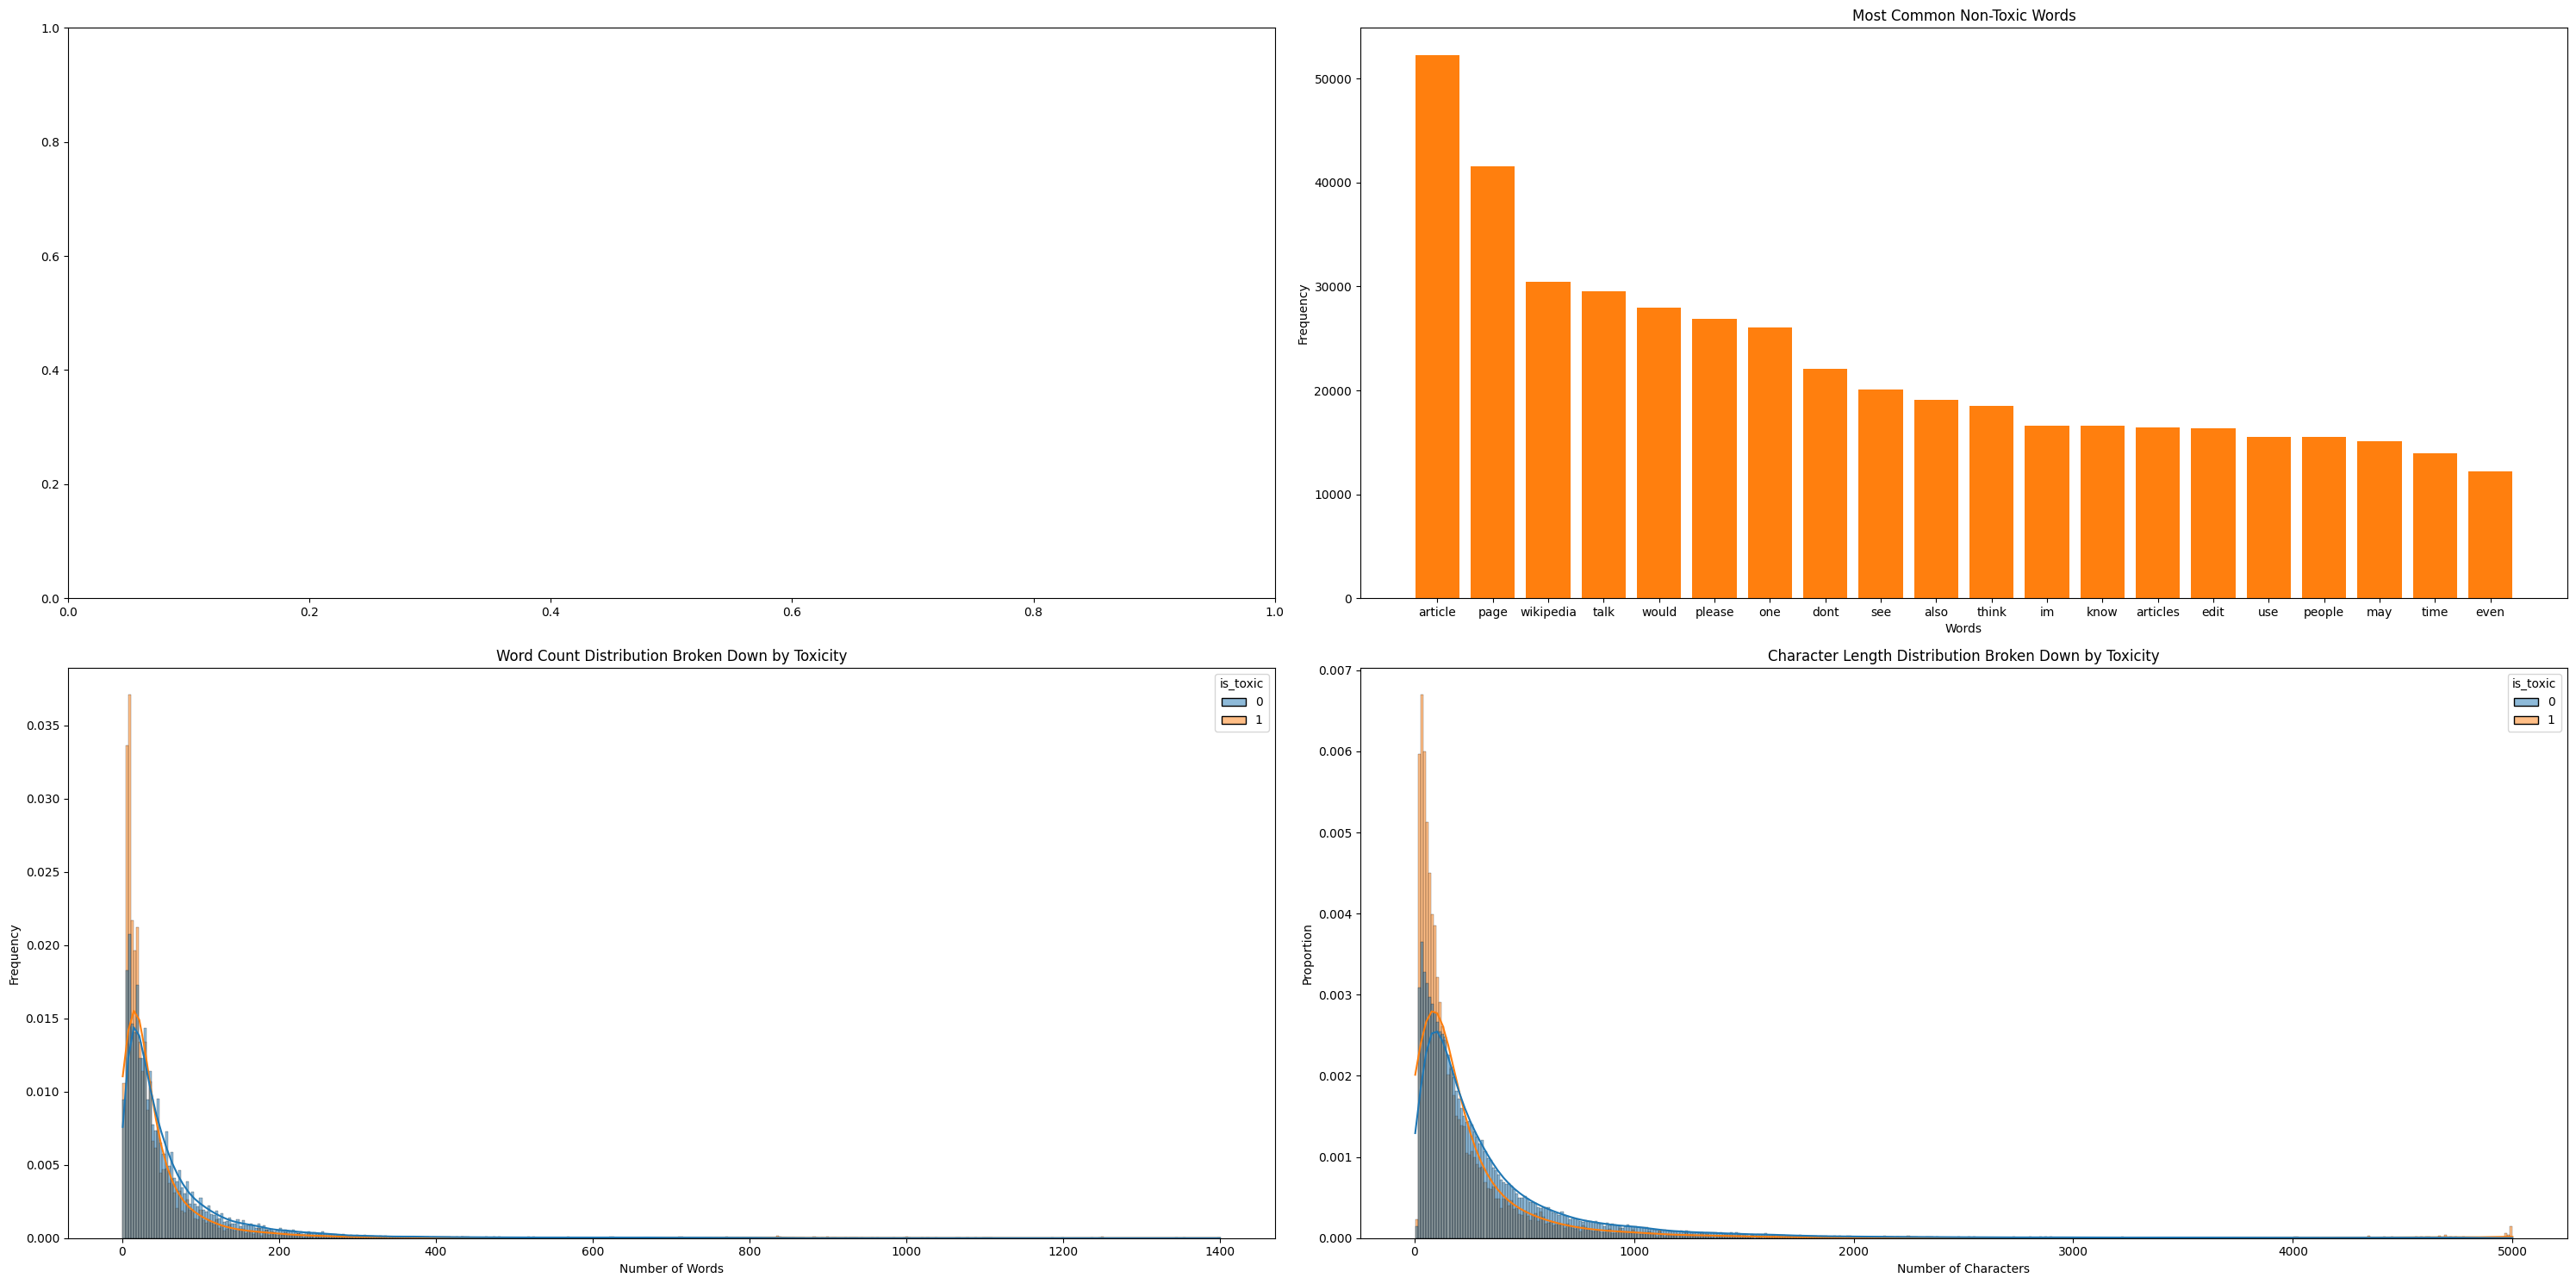

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(30, 15))


# ================= Toxic Words ====================


# Get toxic/non-toxic words, split and create dataframe out of split, flatten into series, and count
toxic_words = toxic_df \
    .str.split(expand=True) \
    .stack() \
    .value_counts()

non_toxic_words = non_toxic_df \
    .str.split(expand=True) \
    .stack() \
    .value_counts()


# Filter out stop words
toxic_words = toxic_words[~toxic_words.index.isin(stop_words)]
non_toxic_words = non_toxic_words[~non_toxic_words.index.isin(stop_words)]
top_n_words = 20


# Plot top n Toxic Words
# axes[0,0].bar(toxic_words.head(top_n_words).index, toxic_words.head(top_n_words).values, color='tab:blue')
# axes[0,0].set_title('Most Common Toxic Words')
# axes[0,0].set_xlabel('Words')
# axes[0,0].set_ylabel('Frequency')


# Plot top n Non-Toxic Words
axes[0,1].bar(non_toxic_words.head(top_n_words).index, non_toxic_words.head(top_n_words).values, color='tab:orange')
axes[0,1].set_title('Most Common Non-Toxic Words')
axes[0,1].set_xlabel('Words')
axes[0,1].set_ylabel('Frequency')


# ================= Toxic Words ====================


# ================= Word and Character Distribution by Toxicity ====================


# Get number of bins using Freedman–Diaconis rule since the graph is skewed
sns.histplot(
             data=jigsaw_cleaned_df,
             x=jigsaw_cleaned_df['comment_text'].str.split().str.len(), 
             bins=415, 
             hue=jigsaw_cleaned_df['is_toxic'],
             stat="density",  # Probability Density
             common_norm=False,  # Each subset is normalized independently (looking at each classes' shape)
             kde=True,
             palette=['tab:blue', 'tab:orange'],
             ax=axes[1,0])
axes[1,0].set_title('Word Count Distribution Broken Down by Toxicity')
axes[1,0].set_xlabel('Number of Words')
axes[1,0].set_ylabel('Frequency')


sns.histplot(
             data=jigsaw_cleaned_df,
             x=jigsaw_cleaned_df['comment_text'].str.len(),
             bins=415, 
             hue=jigsaw_cleaned_df['is_toxic'],
             stat="density",
             common_norm=False,
             kde=True,
             palette=['tab:blue', 'tab:orange'], 
             ax=axes[1,1]
)
axes[1,1].set_title('Character Length Distribution Broken Down by Toxicity')
axes[1,1].set_xlabel('Number of Characters')
axes[1,1].set_ylabel('Proportion')


# ================= Word and Character Distribution by Toxicity ====================

plt.tight_layout()
plt.show()

### N-grams

In [16]:
# More useful to detect duplicate/near-duplicates, patterns, etc.

# for n in range(2, 5):
    # Generate Series of lists n-grams
    # n_grams = jigsaw_cleaned_df['comment_text'].apply(lambda x: generate_grams(x, n))
    # Convert Series of lists to DataFrame (each column is a n-gram)
    # n_gram_df = pd.DataFrame(n_grams.tolist())

    # Create a Series of string n-grams and count
    # n_gram_counts = n_gram_df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1).value_counts()
    # n_gram_counts = n_gram_counts.drop(index=0)
    # print(n_gram_counts.head(10))

In [17]:
# from collections import Counter
# test_n_grams = jigsaw_cleaned_df['comment_text'].apply(lambda x: generate_grams(x, n=2))
# flat_n_grams = [n_gram for n_grams_lst in test_n_grams for n_gram in n_grams_lst]
# dictionary of n-grams and their counts
# n_gram_counts = Counter(flat_n_grams)
# n_grams_df = pd.DataFrame(n_gram_counts.items(), columns=['n_gram', 'count']).sort_values(by='count', ascending=False)
# n_grams_df.info()

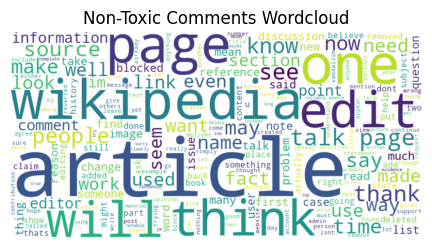

In [18]:
toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(toxic_df))
non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_toxic_df))

# Plot the wordclouds
# plt.figure(figsize=(20, 10))
# plt.subplot(2, 1, 1)
# plt.imshow(toxic_wordcloud, interpolation='bilinear')
# plt.title('Toxic Comments Wordcloud')
# plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Non-Toxic Comments Wordcloud')
plt.axis('off')

plt.tight_layout()
plt.show()

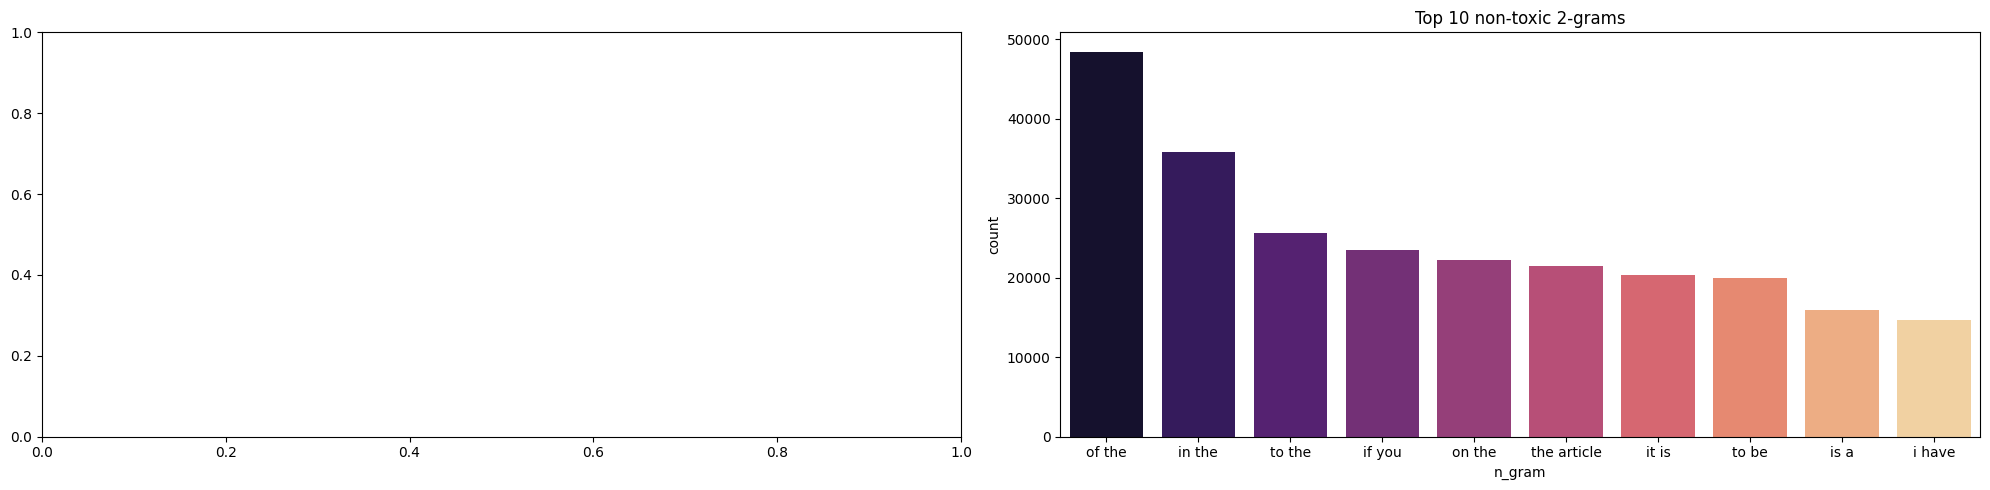

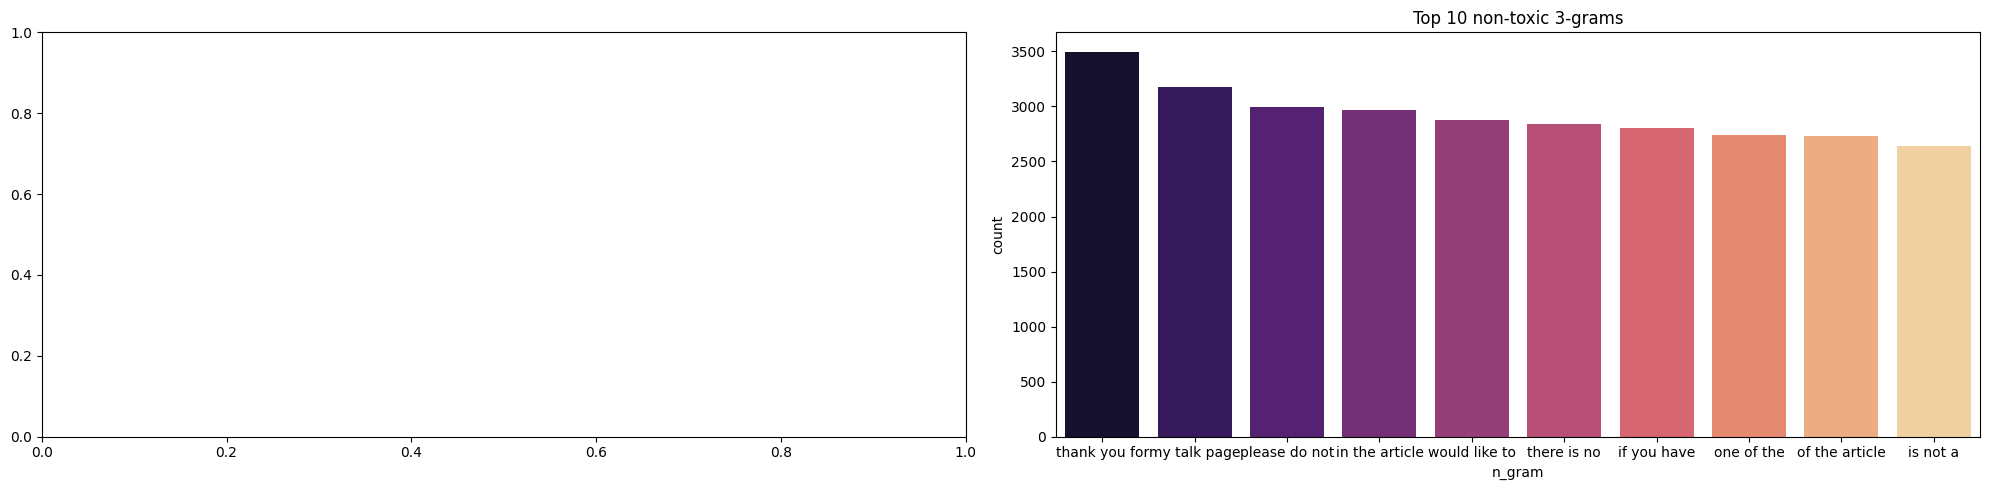

In [19]:
from collections import Counter
for n in range(2, 4):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    # ===== Generate Series of lists n-grams =====

    toxic_ngrams_series = toxic_df.apply(lambda x: generate_grams(x, n)).reset_index(drop=True)
    non_toxic_ngrams_series = non_toxic_df.apply(lambda x: generate_grams(x, n)).reset_index(drop=True)

    # ===== Generate Series of lists n-grams =====

    
    # ===== Flatten n-grams into one list and Count occurences of each n-gram ===== 
    
    flat_toxic_ngrams = [n_gram for n_grams_lst in toxic_ngrams_series for n_gram in n_grams_lst]
    flat_non_toxic_ngrams = [n_gram for n_grams_lst in non_toxic_ngrams_series for n_gram in n_grams_lst]

    toxic_n_gram_counts = Counter(flat_toxic_ngrams)
    non_toxic_n_gram_counts = Counter(flat_non_toxic_ngrams)

    # ===== Flatten n-grams into one list and Count occurences of each n-gram ===== 


    # ===== Create dataframes from n_gram_counts =====
    
    toxic_n_gram_counts_df = pd.DataFrame(toxic_n_gram_counts.items(), columns=['n_gram', 'count']) \
                         .sort_values(by='count', ascending=False)
    toxic_n_gram_counts_df['n_gram'] = toxic_n_gram_counts_df['n_gram'].apply(lambda x: ' '.join(x))


    non_toxic_n_gram_counts_df = pd.DataFrame(non_toxic_n_gram_counts.items(), columns=['n_gram', 'count']) \
                         .sort_values(by='count', ascending=False)
    non_toxic_n_gram_counts_df['n_gram'] = non_toxic_n_gram_counts_df['n_gram'].apply(lambda x: ' '.join(x))

    # ===== Create dataframes from n_gram_counts =====


    # sns.barplot(data=toxic_n_gram_counts_df.head(10), x='n_gram', y='count', ax=axes[0], palette='magma').set_title(f'Top 10 toxic {n}-grams')
    sns.barplot(data=non_toxic_n_gram_counts_df.head(10), x='n_gram', y='count', ax=axes[1], palette='magma').set_title(f'Top 10 non-toxic {n}-grams')
    
    plt.tight_layout()
    plt.show()
    

# Vectorize Comments

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(2,3),
    max_features=10000,
    max_df=0.8,
    stop_words='english'
)

vectorized_text = tfidf_vectorizer.fit_transform(jigsaw_cleaned_df['comment_text'])
target = jigsaw_cleaned_df['is_toxic']

In [21]:
print("N-gram matrix for TfidfVectorizer")
print(vectorized_text.toarray())
print("N-gram shape for TfidfVectorizer")
print(vectorized_text.shape)
print("Feature names (n-grams) for TfidfVectorizer")
print(tfidf_vectorizer.get_feature_names_out())

N-gram matrix for TfidfVectorizer
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
N-gram shape for TfidfVectorizer
(159571, 10000)
Feature names (n-grams) for TfidfVectorizer
['084080 backgroundcolorf5fffa'
 '084080 backgroundcolorf5fffa verticalaligntop' '10 minutes' ...
 'youve seen' 'ytmndin ytmndin' 'ytmndin ytmndin ytmndin']


# Model

In [22]:
from run_models import (
    run_random_forest_model,
    run_class_weight_models,
)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    vectorized_text,
    target,
    test_size=0.2,
    random_state=18,
)

In [24]:
rf_scores = run_random_forest_model(
                x_train,
                y_train,
                x_test,
                y_test,
                total_trees=1200,
                depth=10,
                class_weight='balanced'
            )

In [25]:
# Classifier models expect a dense numpy array
classifier_weight_model_scores = run_class_weight_models(
                                x_train.toarray(),
                                y_train,
                                x_test.toarray(),
                                y_test,
                                class_weight='balanced',
                            )

In [26]:
rf_scores

[{'num_trees': 50,
  'classification_scores': {'0': {'precision': 0.9695961276660112,
    'recall': 0.22375815966767898,
    'f1-score': 0.36360542288275,
    'support': 28647.0},
   '1': {'precision': 0.12120613341764148,
    'recall': 0.9384944920440637,
    'f1-score': 0.21468570628587427,
    'support': 3268.0},
   'accuracy': 0.2969450101832994,
   'macro avg': {'precision': 0.5454011305418264,
    'recall': 0.5811263258558713,
    'f1-score': 0.2891455645843121,
    'support': 31915.0},
   'weighted avg': {'precision': 0.8827235442035744,
    'recall': 0.2969450101832994,
    'f1-score': 0.34835649185224427,
    'support': 31915.0}}},
 {'num_trees': 100,
  'classification_scores': {'0': {'precision': 0.9700082850041425,
    'recall': 0.20434949558417984,
    'f1-score': 0.3375814543567268,
    'support': 28647.0},
   '1': {'precision': 0.11928129829984543,
    'recall': 0.9446144430844553,
    'f1-score': 0.21181556195965417,
    'support': 3268.0},
   'accuracy': 0.2801503994986

In [27]:
classifier_weight_model_scores

[{'model_name': 'HistGradientBoostingClassifier',
  'classification_scores': {'0': {'precision': 0.9663523017902813,
    'recall': 0.42206862847767657,
    'f1-score': 0.5875264219247309,
    'support': 28647.0},
   '1': {'precision': 0.14672988713085605,
    'recall': 0.8711750305997552,
    'f1-score': 0.2511578668783909,
    'support': 3268.0},
   'accuracy': 0.46805577314742286,
   'macro avg': {'precision': 0.5565410944605687,
    'recall': 0.6466218295387158,
    'f1-score': 0.4193421444015609,
    'support': 31915.0},
   'weighted avg': {'precision': 0.8824254319451614,
    'recall': 0.46805577314742286,
    'f1-score': 0.5530832936812267,
    'support': 31915.0}}},
 {'model_name': 'LogisticRegression',
  'classification_scores': {'0': {'precision': 0.9610555684724482,
    'recall': 0.5771634027995951,
    'f1-score': 0.7212056443698065,
    'support': 28647.0},
   '1': {'precision': 0.17660254231527428,
    'recall': 0.7949816401468788,
    'f1-score': 0.28900383781077926,
    

In [28]:
# plt.figure(figsize=(10, 6))
# plt.plot(acc_score_df['Trees'], acc_score_df['acc_score'], marker='o', linestyle='-')
# plt.title('Random Forest Model Performance (Accuracy Score)')
# plt.xlabel('Trees')
# plt.ylabel('Accuracy Score')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [29]:
# def run_class_weight_models(
#         x_train,
#         y_train,
#         x_val,
#         y_val,
#         class_weight=None,
# ):

In [30]:
# pipeline = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('rf', RandomForestClassifier(random_state=42))
# ])

### What I've Learned

* The jigsaw dataset was downloaded from Kaggle, from their Toxic Comment Classification Challenge.
* There are a lot of toxic comments within this dataset, about 10.17% or 16,000 comments.
* From the histogram plots breaking down the data by toxicity (the bottom two plots), we see that a higher proportion of toxic comments  
  fall into shorter word and character length bins compared to non-toxic ones. Meaning shorter comments are more likely to be toxic relative  
  to other toxic comments. Based off the average word count by toxicity, toxic comments tend to be shorter than non-toxic ones with a mean  
  of 51.3 words compared to 67.1 words. We can infer that toxc comments ofter manifest in short outbursts or quick jabs that involve slurs,  
  insults, etc.
* While vectorizing, I ran into a fun little error: "Unable to allocate 9.26 TiB" for an array with shape (159571, 7973741)"... lol. Looking into it more, my vecotrizers basically built a sparse matrix of 7.9 million tokens which amounts to ~9.26 terrabytes. So I learned the fun way that we should limit our vocabulary size by defining other parameters within the vectorizers. 
* Handling class imbalance